# LSTM for Time-Series
### ADAM, Batch size 256, Sequence Length 50
This notebook is the resultant of three different cross validation experiments

Following code shows how to train a LSTM based RNN with Time-Series data and extrapolates for future patterns. Keras with Tensorflow-GPU backend has been used

#### Header

#### General libs

In [1]:
import os
import time
import pickle
import warnings
from datetime import datetime

#### Data structures

In [2]:
import numpy as np
import pandas as pd
from numpy import newaxis

#### Visualization

In [3]:
import matplotlib.pyplot as plt

#### ML libs

In [4]:
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

#### Deep learning libs

In [69]:


import tensorflow as tf
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LeakyReLU
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import TensorBoard, ReduceLROnPlateau, Callback, ModelCheckpoint
from keras.optimizers import Adam

#### Devices avaliable for Tensorflow backend
Check the last line with __'physical_device_desc'__ flag to confirm the default device. If GPU is available, it should show the specifications for the same

In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12789415133873064896
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1492117094
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5834906909048701692
physical_device_desc: "device: 0, name: GeForce 940M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


#### Hide warnings

In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

#### Callback class to clear the state at the end of epoch

In [7]:
class Model_state_reset(Callback):
    def on_epoch_end(self, epoch, logs={}):
        self.model.reset_states()

#### Data Loader
This module will load the data, transform it to supervised format and return it with train test split

In [9]:
def configure_data(seq_len, data, normalise_window):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    #np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

#### Data normalisers
This method will create 1-lag difference to make the data 'stationary'

In [10]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

#### Model builder
4 layers are there
* 1 Input = Contains feature of sequence length, in this use case
* 1st hidden = maps sequnce length numbered features to hidden unit feature space
* 2nd hidden = maps intermediate features from 1st hidden unit to current hidden unit feature space
* 1 output = Fully connected to work with linear activation for regression type action

__Key points__
* Check the dimensions
* Intermediate layers(except the second last) should have __return_sequences__ flag as true. Because it returns the time step information
* __stateful__ flag should be set to true if information retaining is required in betwen mini-batches. Although state/information/weights should be cleared after epoch by callbacks, otherwise it can suffer vanishing gradients
* Droput layer should be added after activation, specially if relu is used. Prediction net should not contain dropouts.

In [47]:
 def build_model(layers, batch_size, predict = False):
    model = Sequential()

    model.add(LSTM(
        batch_input_shape=(batch_size, layers[1], layers[0]),
        output_dim=layers[1],
        return_sequences=True,stateful=True))
    if not predict:
        model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=True,stateful=True))
    lrelu = LeakyReLU(alpha=0.01)
    model.add(lrelu)
    if not predict:
        model.add(Dropout(0.2))
    
    model.add(LSTM(
        layers[3],
        return_sequences=False,stateful=True))
    lrelu = LeakyReLU(alpha=0.01)
    model.add(lrelu)
    if not predict:
        model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[4]))
    model.add(Activation("linear"))

    adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    start = time.time()
    model.compile(loss="mse", optimizer = adam)
    print("> Compilation Time : ", time.time() - start)
    return model

#### Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time

In [12]:
# def predict_point_by_point(model, data, batch_size):
#     predicted = model.predict(data,batch_size = batch_size)
#     predicted = np.reshape(predicted, (predicted.size,))
#     return predicted

In [13]:
def predict_point_by_point(model, data):
    predicted = model.predict(data, batch_size=1)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

#### Multi point prediction

In [14]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

#### Single point plotting

In [15]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white', figsize=[15,10])
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

#### Multiple points prediction plotting

In [16]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white', figsize=[15,10])
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

#### Input size calculator as per batch

In [17]:
def size_calc(n,m):
    return n - n %m

#### Variable and constant initialisation 

In [18]:
global_start_time = time.time()
epochs  = 100
seq_len = 50
batch_size = 256
layer_arch = [1, 50, 100, 50, 1]

print('> Loading data... ')

> Loading data... 


#### Data loading

In [19]:
with open('ts1.pkl', 'rb') as handle:
    collected_op_type_one = pickle.load(handle)

#### Converting to data frame

In [20]:
ts1_df = pd.DataFrame(collected_op_type_one)

#### Converting the values to numeric

In [21]:
ts1_df['values'] = ts1_df['values'].apply(lambda a:int(a))

In [22]:
len(ts1_df['timestamp'].unique())

143843

#### Total number of timestamps

In [23]:
ts1_df.count()

timestamp    143938
values       143938
dtype: int64

#### Converting to 1-D array

In [24]:
input_array = np.array(ts1_df['values'])

#### Taking differences of consecutive time stamps.

In [25]:
input_array = difference(dataset= input_array)

#### Converting list to numpy arrays

In [26]:
input_array = np.array(input_array)

#### Reshaping to be in (N,1)

In [27]:
input_array = np.reshape(input_array,(-1,1))

In [28]:
input_array.shape

(143937, 1)

#### Scale the data to be in Minimum and Maximum ranges

In [29]:
scale = MinMaxScaler(feature_range=(-1,1))

In [30]:
input_array = scale.fit_transform(input_array)

#### Get Custom train and test split, in supervised learning format

In [31]:
X_train, y_train, X_test, y_test = configure_data(seq_len, input_array, False)

In [32]:
print('X_Train:',len(X_train), 'Y_Train:',len(y_train))
print('X_Test:',len(X_test),'Y_test:',len(y_test))

X_Train: 129497 Y_Train: 129497
X_Test: 14389 Y_test: 14389


In [33]:
print('X_Train shape:',X_train.shape, 'Y_Train shape:',y_train.shape)
print('X_Test shape:', X_test.shape,'Y_test shape:', y_test.shape)

X_Train shape: (129497, 50, 1) Y_Train shape: (129497, 1)
X_Test shape: (14389, 50, 1) Y_test shape: (14389, 1)


#### input data size calculation

In [34]:
required_input_size = size_calc(len(X_train), batch_size)

In [35]:
len(X_train[:required_input_size])

129280

In [36]:
required_validation_size = size_calc(len(X_test), batch_size)

### Callbacks definition

In [37]:
date_stamp = datetime.now().strftime("%Y_%m_%d")

#### Reset the model states after epoch

In [ ]:
reset_state = Model_state_reset()

#### Model check point for best model only to pin point the best one in all epochs

In [38]:
checkpoint = ModelCheckpoint(os.getcwd() + "\\checkpoint\\" + date_stamp + "_weights_adam_"+ str(batch_size)+ '_' 
                             + str(seq_len)+ ".hdf5", monitor='val_loss', 
                             verbose=1, save_best_only=True, save_weights_only = True, mode='min')


#### Tensorboard callback

In [ ]:
tensorboard = TensorBoard(log_dir = os.getcwd() + '\\' + 'logs_cv_result\\' + date_stamp, )

#### Reduce learning rate if validation set loss does not improve for 5 epochs, to avoid plateau

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1) 

#### Build the model

In [41]:
train_start_time = time.time()

In [42]:

model = build_model(layers= layer_arch, batch_size=batch_size, set_weights=False)
model.summary()

print("\n\n\n")



history = model.fit(X_train[:required_input_size], y_train[:required_input_size], batch_size=batch_size, 
                nb_epoch= epochs, 
                validation_data=(X_test[:required_validation_size], y_test[:required_validation_size]), 
                verbose=1, 
                shuffle = False, callbacks=[tensorboard, reduce_lr, checkpoint, reset_state])

print("\n\n End of learning with")

> Compilation Time :  0.015986919403076172
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (256, 50, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (256, 50, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (256, 50, 100)            60400     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (256, 50, 100)            0         
_________________________________________________________________
dropout_2 (Dropout)          (256, 50, 100)            0         
_________________________________________________________________
lstm_3 (LSTM)                (256, 50)                 30200     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (256

129280/129280 [==============================] - 221s 2ms/step - loss: 9.6682e-04 - val_loss: 0.0012

Epoch 00033: val_loss did not improve from 0.00118
Epoch 34/100
129280/129280 [==============================] - 221s 2ms/step - loss: 9.7217e-04 - val_loss: 0.0013

Epoch 00034: val_loss did not improve from 0.00118
Epoch 35/100
129280/129280 [==============================] - 221s 2ms/step - loss: 9.7692e-04 - val_loss: 0.0012

Epoch 00035: val_loss did not improve from 0.00118
Epoch 36/100
129280/129280 [==============================] - 221s 2ms/step - loss: 9.6706e-04 - val_loss: 0.0012

Epoch 00036: val_loss did not improve from 0.00118
Epoch 37/100
129280/129280 [==============================] - 220s 2ms/step - loss: 9.6001e-04 - val_loss: 0.0012

Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.00531440949998796.

Epoch 00037: val_loss improved from 0.00118 to 0.00118, saving model to F:\Repository\temp\checkpoint\2018_08_08_weights_adam_256_50.hdf5
Epoch 38/100
1292

129280/129280 [==============================] - 220s 2ms/step - loss: 8.8818e-04 - val_loss: 0.0012

Epoch 00076: val_loss did not improve from 0.00115
Epoch 77/100
129280/129280 [==============================] - 220s 2ms/step - loss: 8.8650e-04 - val_loss: 0.0012

Epoch 00077: ReduceLROnPlateau reducing learning rate to 0.0022876791190356016.

Epoch 00077: val_loss did not improve from 0.00115
Epoch 78/100
129280/129280 [==============================] - 221s 2ms/step - loss: 8.8274e-04 - val_loss: 0.0012

Epoch 00078: val_loss did not improve from 0.00115
Epoch 79/100
129280/129280 [==============================] - 221s 2ms/step - loss: 8.8452e-04 - val_loss: 0.0012

Epoch 00079: val_loss did not improve from 0.00115
Epoch 80/100
129280/129280 [==============================] - 220s 2ms/step - loss: 8.8387e-04 - val_loss: 0.0012

Epoch 00080: val_loss did not improve from 0.00115
Epoch 81/100
129280/129280 [==============================] - 220s 2ms/step - loss: 8.7930e-04 - val_l

In [43]:
print('Training duration (s) : ', (time.time() - train_start_time)/60,'minutes')

Training duration (s) :  372.3384598692258 minutes


#### Plot of training history

In [63]:
history.history.keys()

dict_keys(['loss', 'val_loss', 'lr'])

In [67]:
plt.close()


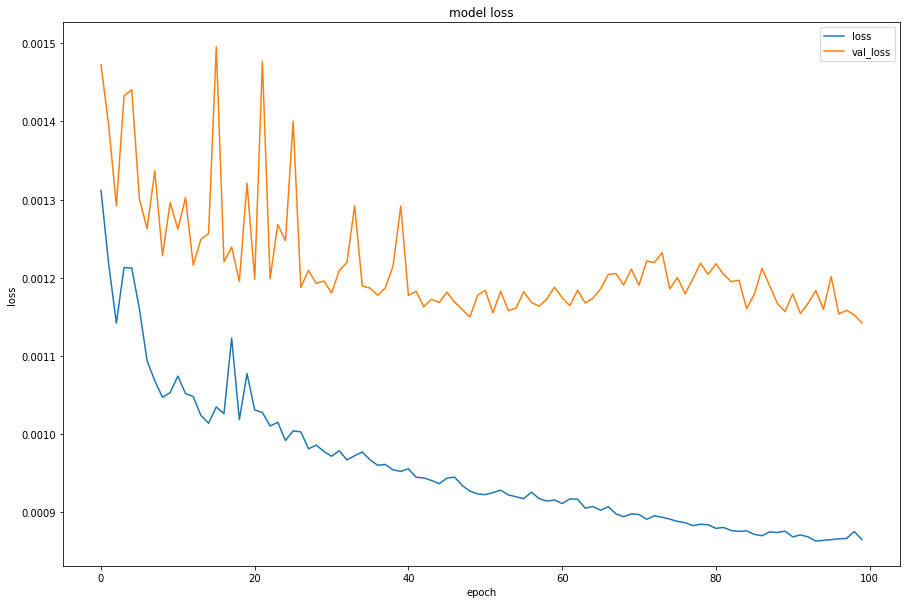

In [68]:
plt.figure(figsize=(15,10)) 


#plt.ylim(0.001)
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['loss', 'val_loss'], loc='best') 

# Prediction Net
#### Create new model for online learning

In [48]:
new_model = build_model(layers=layer_arch, batch_size = 1, predict = True)
#prediction_array[optimizer_unit] = predict_point_by_point(new_model, X_test)
    

> Compilation Time :  0.01396632194519043


In [49]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (1, 50, 50)               10400     
_________________________________________________________________
lstm_8 (LSTM)                (1, 50, 100)              60400     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (1, 50, 100)              0         
_________________________________________________________________
lstm_9 (LSTM)                (1, 50)                   30200     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (1, 50)                   0         
_________________________________________________________________
dense_3 (Dense)              (1, 1)                    51        
_________________________________________________________________
activation_3 (Activation)    (1, 1)                    0         
Total para

#### Load the best model weights

In [50]:
new_model.load_weights('./checkpoint/' + date_stamp + "_weights_adam_"+ str(batch_size)+ '_' 
                             + str(seq_len)+ ".hdf5")

In [51]:
prediction_array = predict_point_by_point(new_model, X_test)

In [52]:
plt.close()

### Plotting
plot predictions together

In [53]:
window_size = 400


========== Prediction plot for limited Time units


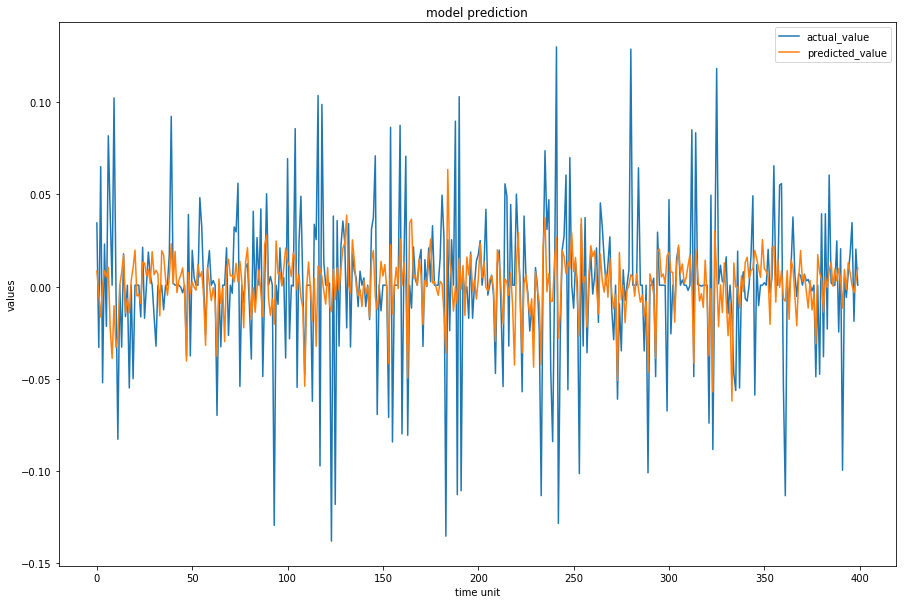

In [54]:

print("\n========== Prediction plot for limited Time units")
plt.close()
plt.figure(figsize=(15,10))
plt.plot(y_test[:window_size])

plt.plot(prediction_array[:400]) 
plt.title('model prediction') 
plt.ylabel('values') 
plt.xlabel('time unit') 
plt.legend(['actual_value', 'predicted_value'], loc='best')
plt.plot();
plt.pause(0.05)


========== Prediction plot for limited Time units


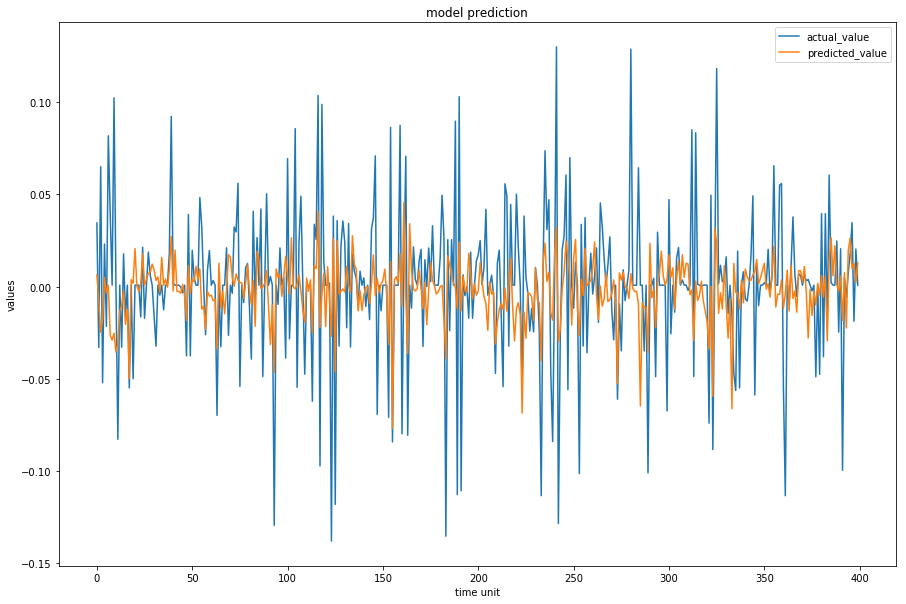

In [80]:

# print("\n========== Prediction plot for limited Time units")
# plt.close()
# plt.figure(figsize=(15,10))
# plt.plot(y_test[:window_size])

# plt.plot(prediction_array[:400]) 
# plt.title('model prediction') 
# plt.ylabel('values') 
# plt.xlabel('time unit') 
# plt.legend(['actual_value', 'predicted_value'], loc='best')
# plt.plot();
# plt.pause(0.05)

#### RMSE

In [55]:
y_test.shape

(14389, 1)

In [56]:
y_test_reshaped = np.reshape(y_test,(y_test.shape[0],))

print("\nRMSE:")
print(np.sqrt(metrics.mean_squared_error(y_test_reshaped, prediction_array)))
print("\nMAE:")
print(metrics.mean_absolute_error(y_test_reshaped, prediction_array))

print("=======================")


RMSE:
0.03394384421846832

MAE:
0.02198134335702457
